In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics as sk_metrics
from sklearn.metrics import classification_report

import data
import uncertainty_estimation as ue
from main_bayesian import getModel
import config_bayesian as cfg
import utils
import torch
import metrics
from torch.nn import functional as F
import config_bayesian as cfg
import pandas as pd


In [40]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)
print(torch.cuda.device_count())
print(torch.version.cuda) 

True
cuda:0
1
11.0


In [41]:
source = 0 # 0: work computer, 1: laptop. NOTE: also change in data.py

## OOD Detection

In [42]:
trainsetOOD, testsetOOD, inputs, num_classes = data.getDataset('OOD', augmentation=cfg.augmentation)
train_loaderOOD, valid_loaderOOD, test_loaderOOD = data.getDataloader(trainsetOOD, testsetOOD, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)

trainset, testset, inputs, num_classes = data.getDataset('POCUS', augmentation=cfg.augmentation)
train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, cfg.valid_size, batch_size=1, num_workers=cfg.num_workers)

ckpt_name = 'model_custom_bbb_relu_2023-10-19_2VP1X'
net_type = 'custom' # 'alexnet'

loc_pc = '/home/marisa/Documents'
loc_lap = 'C:/Users/maris/Documents/Thesis'
locs = [loc_pc, loc_lap]
loc = locs[source]

# Load model
ckpt = f'{loc}/PyTorch-BayesianCNN/checkpoints/POCUS/bayesian/{ckpt_name}.pt'
layer_type = cfg.layer_type
activation_type = cfg.activation_type

net = getModel(net_type, inputs, num_classes, priors=None, layer_type=layer_type, activation_type=activation_type)
net = net.to(device)
net.load_state_dict(torch.load(ckpt, map_location=device)["model_state_dict"])
net.train() # should this be train or eval?

found data in  /home/marisa/Documents/Thesis/Data/OOD-examples/  :  8
length of train set:  8
found data in  /home/marisa/Documents/Thesis/Data/OOD-examples/  :  8
found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Train/  :  1236
found data in  /home/marisa/Documents/Thesis/Data/POCUS_and_US/Test/  :  531


BBBCustom(
  (conv1): BBBConv2d()
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BBBConv2d()
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): BBBConv2d()
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): BBBConv2d()
  (act4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): BBBConv2d()
  (act5): ReLU()
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): FlattenLayer()
  (fc1): BBBLinear()
  (act6): ReLU()
  (fc2): BBBLinear()
)

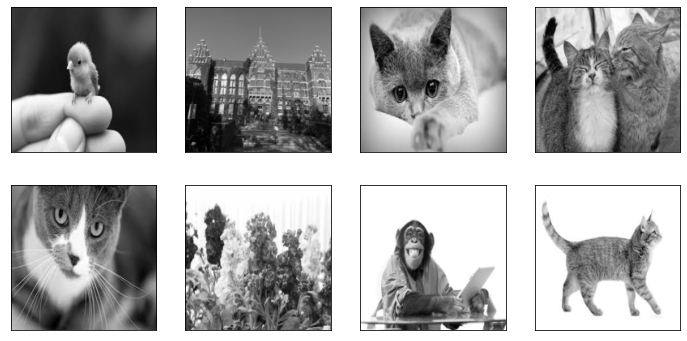

In [43]:
# plot all images in OOD test set
fig = plt.figure(figsize=(12,6))
rows, cols = 2,4


for i, (inputs, targets) in enumerate(test_loaderOOD):

   fig.add_subplot(rows, cols, i+1)
   plt.imshow(inputs.squeeze(), cmap='gray')
   plt.xticks([])
   plt.yticks([])
plt.show()


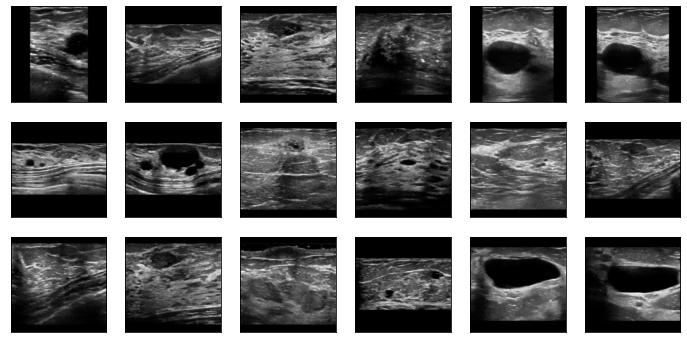

In [44]:
# plot some images in POCUS test set
fig = plt.figure(figsize=(12,6))
rows, cols = 3,6

for i in range(18):

   inputs, targets = test_loader.dataset[i]
   fig.add_subplot(rows, cols, i+1)
   plt.imshow(inputs.squeeze(), cmap='gray')
   plt.xticks([])
   plt.yticks([])
plt.show()

In [45]:
def evaluate_uncertainties(net, testset):

    n_samples = len(testset)
    
    uncertainties = []

    for idx in range(n_samples):
        sample, truth = testset[idx]
        sample = sample.to(device)

        pred, epi_norm, ale_norm = ue.get_uncertainty_per_image(net, sample, T=32, normalized=True)
        pred, epi_soft, ale_soft = ue.get_uncertainty_per_image(net, sample, T=32, normalized=False)

        pred = int(np.argmax(pred))
        uncertainties.append([epi_norm[0], 
                              epi_norm[1],
                              epi_norm[2],
                              ale_norm[0],
                              ale_norm[1],
                              ale_norm[2], 
                              epi_soft[0], 
                              epi_soft[1], 
                              epi_soft[2], 
                              ale_soft[0], 
                              ale_soft[1], 
                              ale_soft[2], 
                              epi_norm[pred],
                              ale_norm[pred],
                              epi_soft[pred],
                              ale_soft[pred],
                              truth==pred, 
                              truth, 
                              pred
                              ])


    return uncertainties

In [46]:
uncertainties_OOD = evaluate_uncertainties(net, testsetOOD)
df_OOD = pd.DataFrame(uncertainties_OOD, columns=['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'ale_norm_0', 'ale_norm_1', 'ale_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2', 'ale_soft_0', 'ale_soft_1', 'ale_soft_2', 'epi_norm_pred', 'ale_norm_pred', 'epi_soft_pred', 'ale_soft_pred', 'correct', 'truth', 'pred'])

In [47]:
uncertainties_POCUS = evaluate_uncertainties(net, testset)
df_POCUS = pd.DataFrame(uncertainties_POCUS, columns=['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'ale_norm_0', 'ale_norm_1', 'ale_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2', 'ale_soft_0', 'ale_soft_1', 'ale_soft_2', 'epi_norm_pred', 'ale_norm_pred', 'epi_soft_pred', 'ale_soft_pred', 'correct', 'truth', 'pred'])

In [48]:
df_OOD.describe()

,epi_norm_0,epi_norm_1,epi_norm_2,ale_norm_0,ale_norm_1,ale_norm_2,epi_soft_0,epi_soft_1,epi_soft_2,ale_soft_0,ale_soft_1,ale_soft_2,epi_norm_pred,ale_norm_pred,epi_soft_pred,ale_soft_pred,truth,pred
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.0,8.000000
mean,0.261087,0.237668,0.190368,-0.238765,-0.154207,-0.084757,0.340347,0.277718,0.205029,-0.377011,-0.188003,-0.097672,0.259363,-0.234241,0.349376,-0.389108,0.0,0.125000
std,0.049120,0.062906,0.032368,0.061742,0.077236,0.029443,0.054436,0.068449,0.043961,0.103386,0.083812,0.046575,0.047797,0.061336,0.040785,0.076060,0.0,0.353553
min,0.201432,0.106521,0.122638,-0.340511,-0.223241,-0.124076,0.245761,0.191328,0.117239,-0.504570,-0.325825,-0.176758,0.201432,-0.340511,0.302786,-0.504570,0.0,0.000000
25%,0.227419,0.218882,0.182409,-0.259851,-0.198978,-0.094801,0.321803,0.233010,0.197165,-0.423555,-0.235621,-0.112649,0.227419,-0.256561,0.325605,-0.423555,0.0,0.000000
50%,0.252059,0.258633,0.199015,-0.252934,-0.189808,-0.093563,0.338282,0.281334,0.205605,-0.385018,-0.187042,-0.096624,0.252059,-0.244355,0.338282,-0.385018,0.0,0.000000
75%,0.288248,0.275586,0.203037,-0.218842,-0.126848,-0.077716,0.366643,0.317334,0.223558,-0.358493,-0.136098,-0.086942,0.284800,-0.207860,0.366643,-0.358493,0.0,0.000000
max,0.349537,0.299537,0.235003,-0.143594,0.004000,-0.021169,0.432097,0.392486,0.270417,-0.157327,-0.083285,-0.010853,0.349537,-0.143594,0.432097,-0.254102,0.0,1.000000


In [49]:
df_POCUS.describe()

,epi_norm_0,epi_norm_1,epi_norm_2,ale_norm_0,ale_norm_1,ale_norm_2,epi_soft_0,epi_soft_1,epi_soft_2,ale_soft_0,ale_soft_1,ale_soft_2,epi_norm_pred,ale_norm_pred,epi_soft_pred,ale_soft_pred,truth,pred
count,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000
mean,0.214540,0.183465,0.151313,-0.183028,-0.104744,-0.046836,0.305735,0.275377,0.180846,-0.297354,-0.207494,-0.074026,0.206099,-0.163587,0.308080,-0.302539,0.681733,0.303202
std,0.035387,0.039408,0.030997,0.057773,0.054154,0.034574,0.040938,0.057012,0.038208,0.071869,0.081169,0.039099,0.040310,0.069070,0.044680,0.074422,0.809394,0.495612
min,0.099469,0.055267,0.049978,-0.377173,-0.267821,-0.164580,0.180473,0.091917,0.031317,-0.520541,-0.418559,-0.246924,0.087692,-0.377173,0.174073,-0.520541,0.000000,0.000000
25%,0.191292,0.154722,0.130235,-0.222638,-0.144673,-0.069313,0.279452,0.234973,0.161760,-0.342596,-0.266747,-0.092248,0.180458,-0.208496,0.279420,-0.350211,0.000000,0.000000
50%,0.215801,0.182836,0.153638,-0.183958,-0.101744,-0.048191,0.307035,0.277297,0.182921,-0.294088,-0.206975,-0.075177,0.208287,-0.164987,0.310999,-0.305881,0.000000,0.000000
75%,0.239230,0.212313,0.173575,-0.141811,-0.064608,-0.025670,0.334736,0.316576,0.200458,-0.247867,-0.153511,-0.052783,0.233592,-0.122043,0.339170,-0.253809,1.000000,1.000000
max,0.305580,0.286676,0.233174,-0.000836,0.055700,0.059545,0.421825,0.427733,0.294265,-0.099951,0.018173,0.047139,0.305580,0.018432,0.421825,-0.078650,2.000000,2.000000


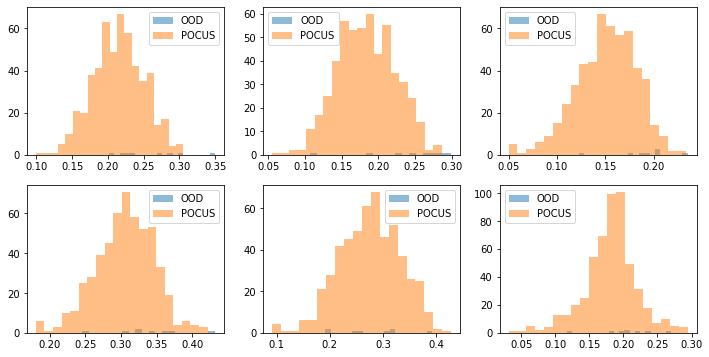

In [50]:
# plot the epistemic uncertainties for the OOD test set and the POCUS test set and label by which set they belong to
fig = plt.figure(figsize=(12,6))
rows, cols = 2,3

columns = ['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2']

for col in columns:
    fig.add_subplot(rows, cols, columns.index(col)+1)
    plt.hist(df_OOD[col], bins=20, alpha=0.5, label='OOD')
    plt.hist(df_POCUS[col], bins=20, alpha=0.5, label='POCUS')
    plt.legend()




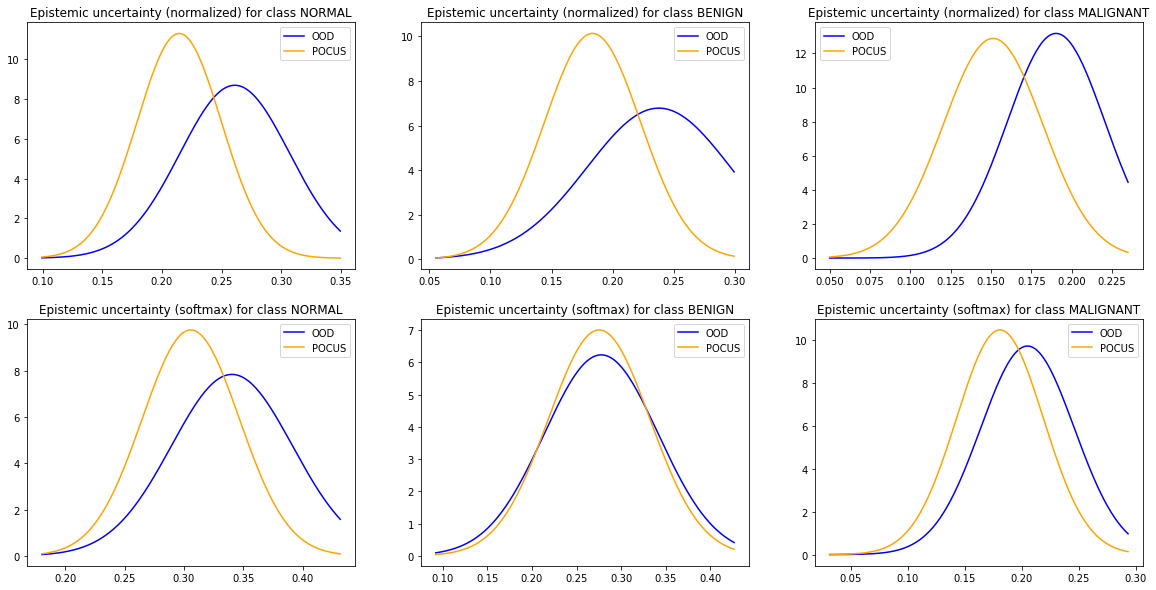

In [51]:
from scipy.stats import norm
fig = plt.figure(figsize=(20,10))
rows, cols = 2,3

columns = ['epi_norm_0', 'epi_norm_1', 'epi_norm_2', 'epi_soft_0', 'epi_soft_1', 'epi_soft_2']
titles = ['Epistemic uncertainty (normalized) for class NORMAL', 'Epistemic uncertainty (normalized) for class BENIGN', 'Epistemic uncertainty (normalized) for class MALIGNANT','Epistemic uncertainty (softmax) for class NORMAL','Epistemic uncertainty (softmax) for class BENIGN','Epistemic uncertainty (softmax) for class MALIGNANT']

for i, col in enumerate(columns):
    # plot normal distribution with mean and std values from the column 
    fig.add_subplot(rows, cols, columns.index(col)+1)
    x_axis = np.arange(min(min(df_OOD[col]), min(df_POCUS[col])), max(max(df_OOD[col]),max(df_POCUS[col])), 0.001)
    plt.plot(x_axis, norm.pdf(x_axis,np.mean(df_OOD[col]), np.std(df_OOD[col])), label='OOD', color='blue')
    plt.plot(x_axis, norm.pdf(x_axis,np.mean(df_POCUS[col]), np.std(df_POCUS[col])), label='POCUS', color='orange')
    plt.legend()
    plt.title(titles[i])

plt.show()
    

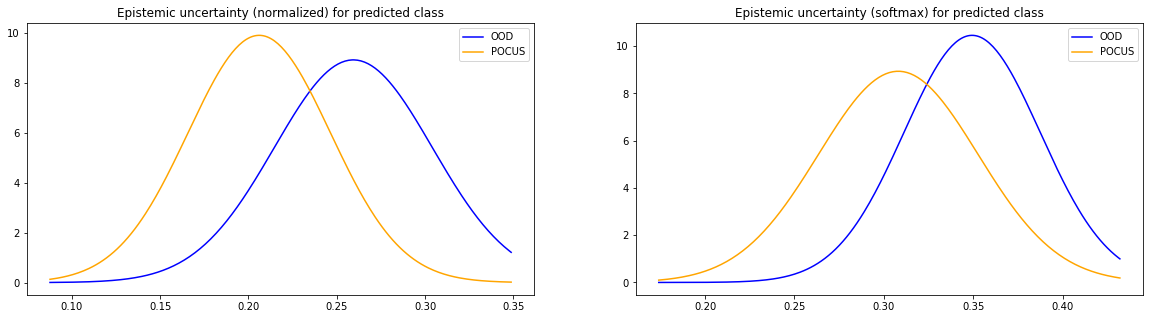

In [57]:
columns = ['epi_norm_pred', 'epi_soft_pred']
titles = ['Epistemic uncertainty (normalized) for predicted class', 'Epistemic uncertainty (softmax) for predicted class']
fig = plt.figure(figsize=(20,5))
rows, cols = 1,2

for i, col in enumerate(columns):
    # plot normal distribution with mean and std values from the column 
    fig.add_subplot(rows, cols, columns.index(col)+1)
    x_axis = np.arange(min(min(df_OOD[col]), min(df_POCUS[col])), max(max(df_OOD[col]),max(df_POCUS[col])), 0.001)
    plt.plot(x_axis, norm.pdf(x_axis,np.mean(df_OOD[col]), np.std(df_OOD[col])), label='OOD', color='blue')
    plt.plot(x_axis, norm.pdf(x_axis,np.mean(df_POCUS[col]), np.std(df_POCUS[col])), label='POCUS', color='orange')
    plt.legend()
    plt.title(titles[i])

plt.show()

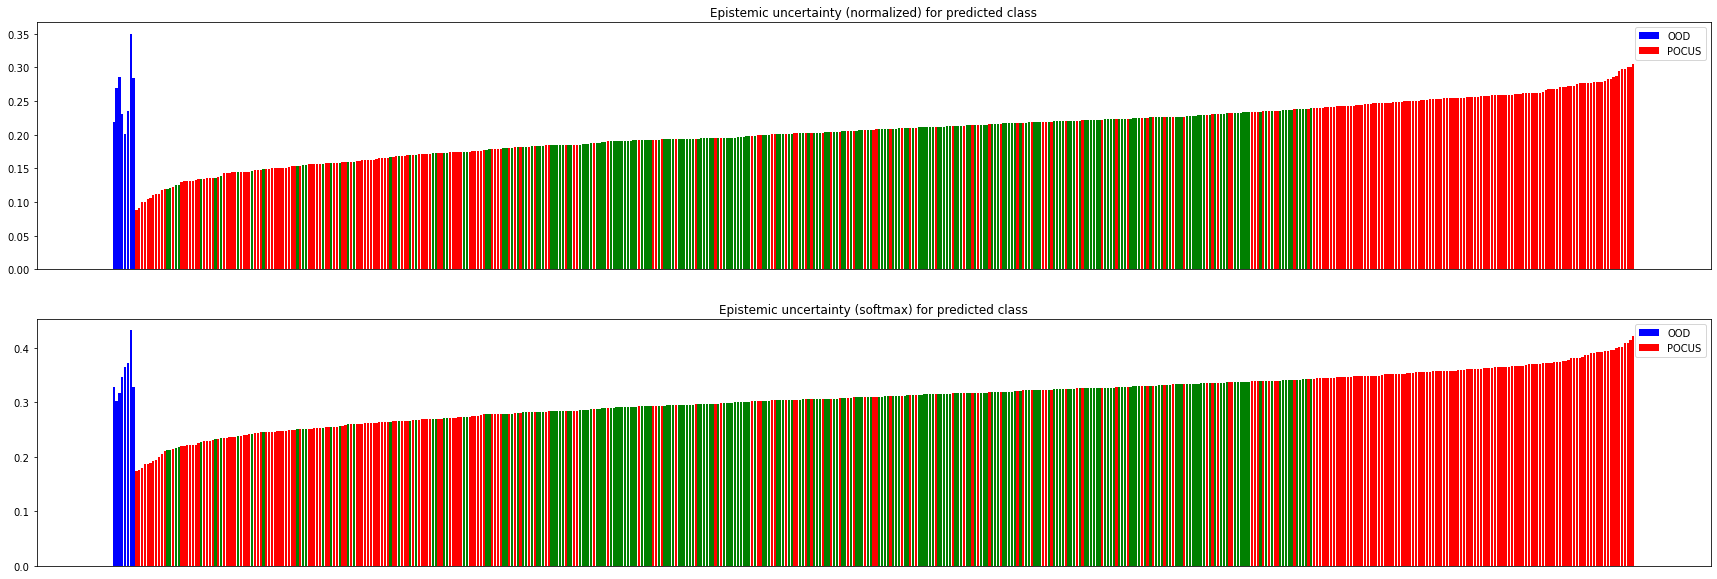

In [81]:
columns = ['epi_norm_pred', 'epi_soft_pred']
titles = ['Epistemic uncertainty (normalized) for predicted class', 'Epistemic uncertainty (softmax) for predicted class']
fig = plt.figure(figsize=(30, 10))
rows, cols = 2,1

for i, col in enumerate(columns):
    # plot normal distribution with mean and std values from the column 
    fig.add_subplot(rows, cols, columns.index(col)+1)

    x_axis_OOD = [f'OOD_{str(elem)}' for elem in np.arange(1, len(df_OOD)+1, 1)]
    x_axis_POCUS = [f'POCUS_{str(elem)}' for elem in np.arange(1, len(df_POCUS)+1, 1)]

    x_axis = x_axis_OOD + x_axis_POCUS

    colordict = dict(zip([True, False], ['green', 'red']))


    plt.bar(x_axis_OOD, df_OOD[col], label='OOD', color='blue')
    plt.bar(x_axis_POCUS, df_POCUS.sort_values(col)[col], label='POCUS', color=df_POCUS['correct'].apply(lambda x: colordict[x]))

    plt.xticks([])
    plt.legend()
    plt.title(titles[i])

plt.show()

In [66]:
x_axis_OOD = [f'OOD_{str(elem)}' for elem in np.arange(1, len(df_OOD)+1, 1)]
x_axis_POCUS = [f'POCUS_{str(elem)}' for elem in np.arange(1, len(df_POCUS)+1, 1)]

x = x_axis_OOD + x_axis_POCUS

print(x)

['OOD_1', 'OOD_2', 'OOD_3', 'OOD_4', 'OOD_5', 'OOD_6', 'OOD_7', 'OOD_8', 'POCUS_1', 'POCUS_2', 'POCUS_3', 'POCUS_4', 'POCUS_5', 'POCUS_6', 'POCUS_7', 'POCUS_8', 'POCUS_9', 'POCUS_10', 'POCUS_11', 'POCUS_12', 'POCUS_13', 'POCUS_14', 'POCUS_15', 'POCUS_16', 'POCUS_17', 'POCUS_18', 'POCUS_19', 'POCUS_20', 'POCUS_21', 'POCUS_22', 'POCUS_23', 'POCUS_24', 'POCUS_25', 'POCUS_26', 'POCUS_27', 'POCUS_28', 'POCUS_29', 'POCUS_30', 'POCUS_31', 'POCUS_32', 'POCUS_33', 'POCUS_34', 'POCUS_35', 'POCUS_36', 'POCUS_37', 'POCUS_38', 'POCUS_39', 'POCUS_40', 'POCUS_41', 'POCUS_42', 'POCUS_43', 'POCUS_44', 'POCUS_45', 'POCUS_46', 'POCUS_47', 'POCUS_48', 'POCUS_49', 'POCUS_50', 'POCUS_51', 'POCUS_52', 'POCUS_53', 'POCUS_54', 'POCUS_55', 'POCUS_56', 'POCUS_57', 'POCUS_58', 'POCUS_59', 'POCUS_60', 'POCUS_61', 'POCUS_62', 'POCUS_63', 'POCUS_64', 'POCUS_65', 'POCUS_66', 'POCUS_67', 'POCUS_68', 'POCUS_69', 'POCUS_70', 'POCUS_71', 'POCUS_72', 'POCUS_73', 'POCUS_74', 'POCUS_75', 'POCUS_76', 'POCUS_77', 'POCUS_78', 